In [1]:
!git clone https://github.com/korfoo12/OptMLProject.git

Cloning into 'OptMLProject'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 142 (delta 76), reused 96 (delta 36), pack-reused 0
Receiving objects: 100% (142/142), 8.42 MiB | 25.28 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [2]:
import sys
sys.path.insert(0, '/kaggle/working/OptMLProject/code/')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Subset

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.models import vgg11

from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt

from lib.models import model
from lib.server import Server
from lib.client import Client
from lib.data_helper import *
from lib.train_helper import *
from lib.plots import plot_loss_epoch

In [4]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [5]:
seed_generators()

In [6]:
train_dataset = CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
train_dataset

100%|██████████| 170498071/170498071 [00:02<00:00, 76512633.81it/s]


Extracting data/cifar-10-python.tar.gz to data


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_dataset = CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
test_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
num_clients = 8
num_classes = 10

In [9]:
proportions = generate_proportions(num_clients,num_classes)

In [10]:
def run_FedAvg(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []

    server.reset_weights()
    for i in range(rounds):
        print(f'>>> Round {i+1} ...')
        server_params = server.net.state_dict()
        clients_params = []
        for client in clients:
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        valid_loss, valid_acc = evaluate(server.net,valid_loader)
        
        print(f'''
Server :
    - training loss = {train_loss:.4f}
    - training accuracy = {train_acc:.4f}
    - validation loss = {valid_loss:.4f}
    - validation accuracy = {valid_acc:.4f}
        ''')
        
        history.append([train_loss, valid_loss, train_acc, valid_acc])
    return history

In [11]:
def run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,**kwargs):
    folds = KFold(n_splits=n_splits,shuffle=True,random_state=42).split(np.arange(len(train_dataset)))

    results = []
    for fold, (train_idx,valid_idx) in enumerate(folds):
        print("="*25)
        print(f"Fold #{fold}")
        print("="*25)

        # create train and validation subsets
        train_subset = Subset(train_dataset, train_idx)
        valid_subset = Subset(train_dataset, valid_idx)

        # split data between users
        partition = partition_by_class(train_subset)
        clients = [Client(i,d,model().to(device)) for i,d in enumerate(split(partition,proportions),start=1)]
        server = Server(model().to(device))
        
        for c in clients:
            print(f"client {c.client_id} : {len(c.dataset)} samples")
        print()
        
        history = run_FedAvg(server,clients,device,train_subset,valid_subset,rounds,epochs,batch_size,optimizer,lr,**kwargs)
        
        plot_loss_epoch(history)
        
        results.append(history[-1][-1])
                
    return torch.tensor(results).mean()

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.8632, Accuracy = 0.6516
client 2 : Loss = 0.3626, Accuracy = 0.8597
client 3 : Loss = 0.5189, Accuracy = 0.8217
client 4 : Loss = 0.6383, Accuracy = 0.7634
client 5 : Loss = 0.3149, Accuracy = 0.8955
client 6 : Loss = 0.3570, Accuracy = 0.8799
client 7 : Loss = 0.7293, Accuracy = 0.7332
client 8 : Loss = 0.6079, Accuracy = 0.7300

Server :
    - training loss = 3.1167
    - training accuracy = 0.1213
    - validation loss = 3.1176
    - validation accuracy = 0.1294
        
>>> Round 2 ...
client 1 : Loss = 0.6491, Accuracy = 0.7520
client 2 : Loss = 0.1819, Accuracy = 0.9291
client 3 : Loss = 0.3402, Accuracy = 0.8760
client 4 : Loss = 0.3648, Accuracy = 0.8653
client 5 : Loss = 0.1656, Accuracy = 0.9365
client 6 : Loss = 0.2035, Accuracy = 0.9254
cli

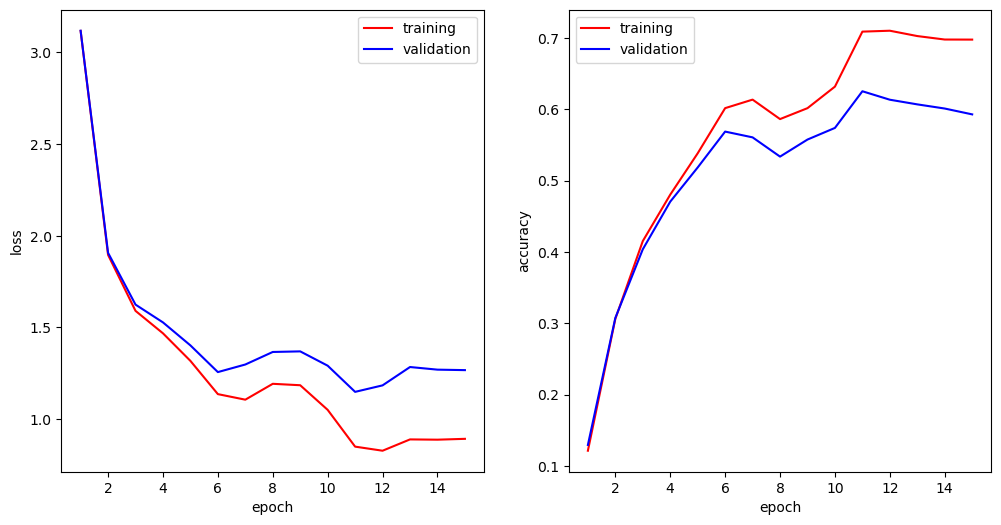

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.6467, Accuracy = 0.7456
client 2 : Loss = 0.3197, Accuracy = 0.8740
client 3 : Loss = 0.5490, Accuracy = 0.8166
client 4 : Loss = 0.4575, Accuracy = 0.8286
client 5 : Loss = 0.9650, Accuracy = 0.7413
client 6 : Loss = 0.4558, Accuracy = 0.8753
client 7 : Loss = 0.7189, Accuracy = 0.7400
client 8 : Loss = 0.5697, Accuracy = 0.7473

Server :
    - training loss = 2.6974
    - training accuracy = 0.1808
    - validation loss = 2.6573
    - validation accuracy = 0.1850
        
>>> Round 2 ...
client 1 : Loss = 0.4147, Accuracy = 0.8432
client 2 : Loss = 0.2874, Accuracy = 0.8813
client 3 : Loss = 0.3497, Accuracy = 0.8703
client 4 : Loss = 0.2727, Accuracy = 0.8969
client 5 : Loss = 0.4071, Accuracy = 0.8464
client 6 : Loss = 0.1822, Accuracy = 0.9264
cli

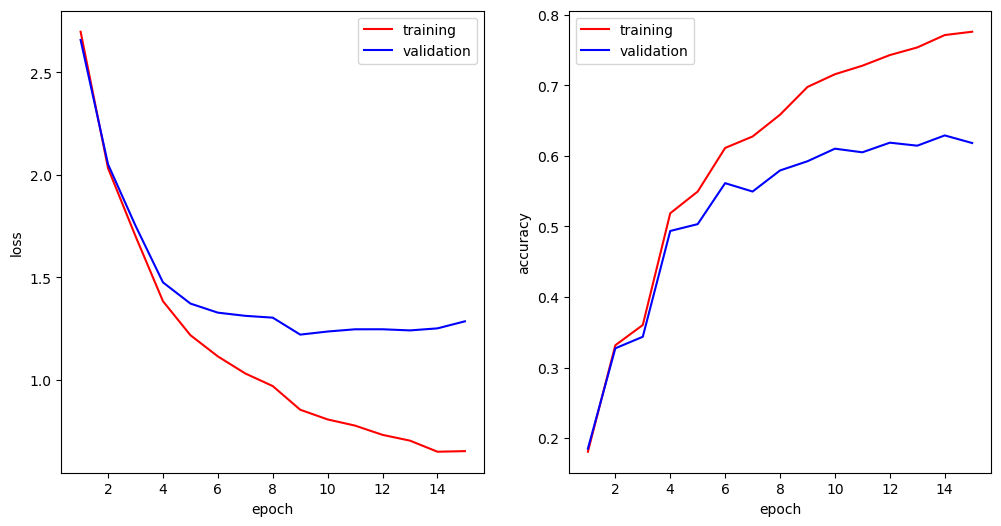

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 0.6178, Accuracy = 0.7541
client 2 : Loss = 0.2815, Accuracy = 0.8858
client 3 : Loss = 0.5233, Accuracy = 0.8156
client 4 : Loss = 0.4292, Accuracy = 0.8379
client 5 : Loss = 0.3988, Accuracy = 0.8592
client 6 : Loss = 0.4188, Accuracy = 0.8808
client 7 : Loss = 0.6370, Accuracy = 0.7712
client 8 : Loss = 0.5812, Accuracy = 0.7424

Server :
    - training loss = 3.0866
    - training accuracy = 0.1105
    - validation loss = 3.1163
    - validation accuracy = 0.1105
        
>>> Round 2 ...
client 1 : Loss = 0.4354, Accuracy = 0.8339
client 2 : Loss = 0.1419, Accuracy = 0.9450
client 3 : Loss = 0.2862, Accuracy = 0.9002
client 4 : Loss = 0.3336, Accuracy = 0.8814
client 5 : Loss = 0.3650, Accuracy = 0.8619
client 6 : Loss = 0.1700, Accuracy = 0.9351
cli

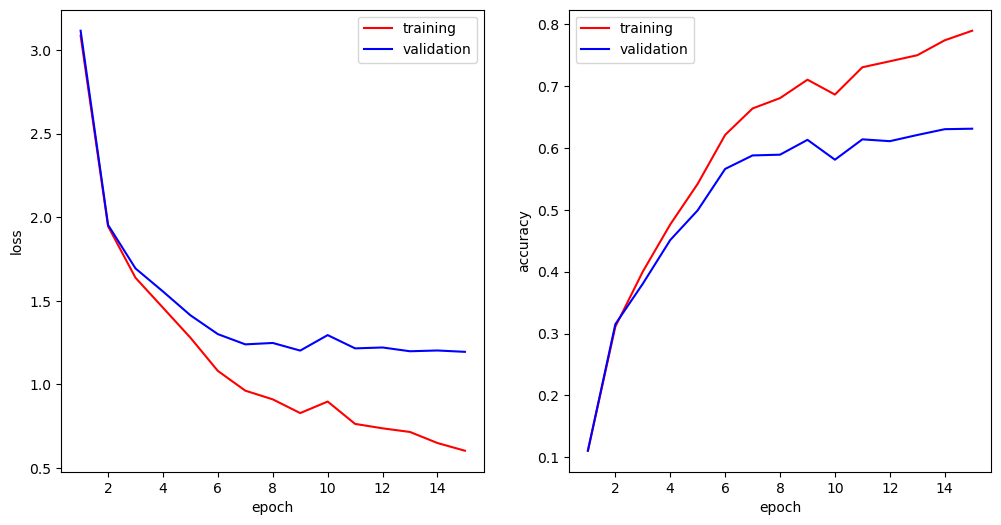

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.6839, Accuracy = 0.7233
client 2 : Loss = 0.3833, Accuracy = 0.8504
client 3 : Loss = 0.6808, Accuracy = 0.7779
client 4 : Loss = 0.4910, Accuracy = 0.8118
client 5 : Loss = 0.4967, Accuracy = 0.8489
client 6 : Loss = 0.3759, Accuracy = 0.8738
client 7 : Loss = 0.6800, Accuracy = 0.7585
client 8 : Loss = 0.6534, Accuracy = 0.7111

Server :
    - training loss = 3.6584
    - training accuracy = 0.1176
    - validation loss = 3.7388
    - validation accuracy = 0.1152
        
>>> Round 2 ...
client 1 : Loss = 0.4498, Accuracy = 0.8289
client 2 : Loss = 0.2119, Accuracy = 0.9121
client 3 : Loss = 0.4245, Accuracy = 0.8536
client 4 : Loss = 0.2850, Accuracy = 0.8932
client 5 : Loss = 0.2070, Accuracy = 0.9206
client 6 : Loss = 0.2262, Accuracy = 0.9209
cli

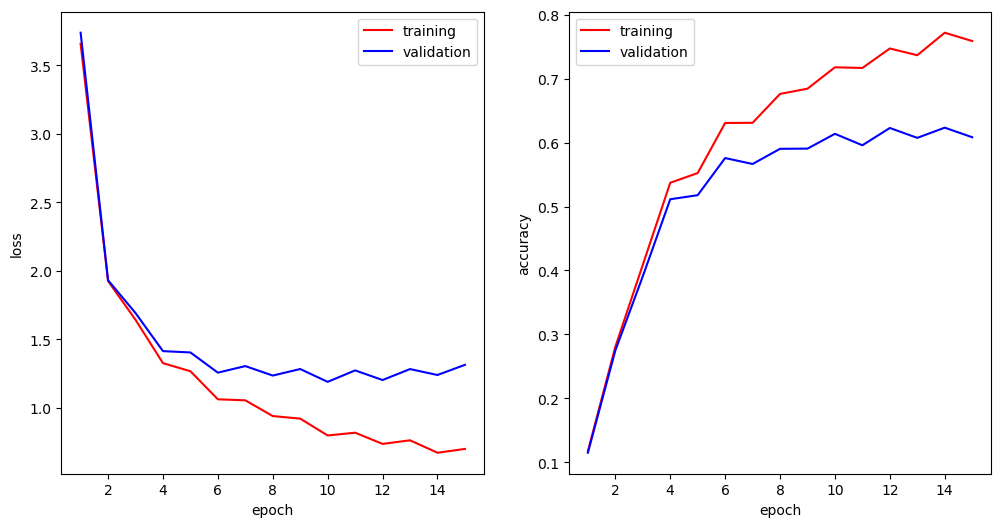

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.6820, Accuracy = 0.7316
client 2 : Loss = 0.3417, Accuracy = 0.8692
client 3 : Loss = 0.5301, Accuracy = 0.8115
client 4 : Loss = 0.4888, Accuracy = 0.8133
client 5 : Loss = 0.2871, Accuracy = 0.8985
client 6 : Loss = 0.3783, Accuracy = 0.8777
client 7 : Loss = 0.7194, Accuracy = 0.7341
client 8 : Loss = 0.5779, Accuracy = 0.7469

Server :
    - training loss = 2.8432
    - training accuracy = 0.1617
    - validation loss = 2.8482
    - validation accuracy = 0.1587
        
>>> Round 2 ...
client 1 : Loss = 0.4560, Accuracy = 0.8267
client 2 : Loss = 0.1959, Accuracy = 0.9215
client 3 : Loss = 0.3475, Accuracy = 0.8686
client 4 : Loss = 0.2587, Accuracy = 0.9085
client 5 : Loss = 0.1646, Accuracy = 0.9471
client 6 : Loss = 0.2013, Accuracy = 0.9316
cli

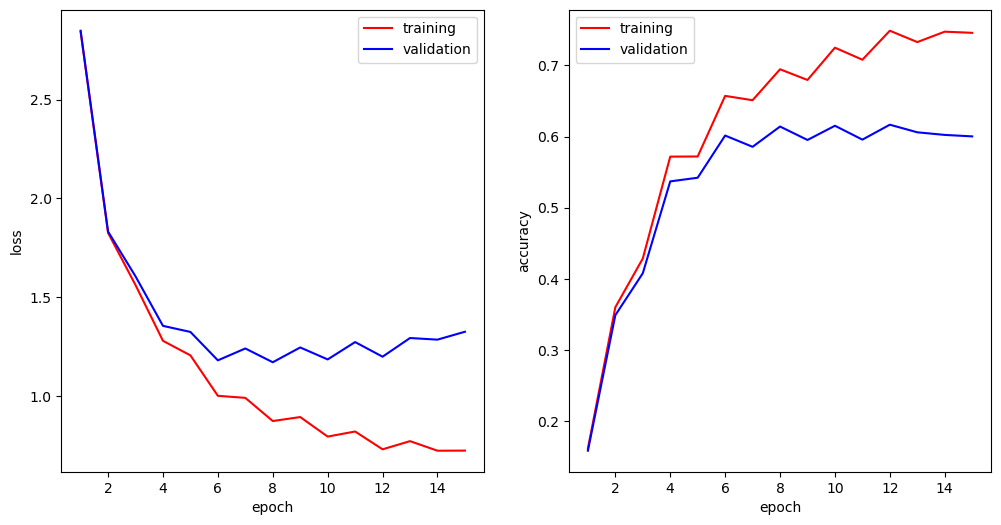

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.9671, Accuracy = 0.6588
client 2 : Loss = 0.1374, Accuracy = 0.9491
client 3 : Loss = 0.2520, Accuracy = 0.9086
client 4 : Loss = 0.3416, Accuracy = 0.8683
client 5 : Loss = 0.1396, Accuracy = 0.9585
client 6 : Loss = 0.1630, Accuracy = 0.9434
client 7 : Loss = 0.3766, Accuracy = 0.8648
client 8 : Loss = 0.4960, Accuracy = 0.7853

Server :
    - training loss = 2.4298
    - training accuracy = 0.2490
    - validation loss = 2.4619
    - validation accuracy = 0.2449
        
>>> Round 2 ...
client 1 : Loss = 0.8549, Accuracy = 0.6848
client 2 : Loss = 0.0789, Accuracy = 0.9689
client 3 : Loss = 0.1793, Accuracy = 0.9382
client 4 : Loss = 0.2979, Accuracy = 0.8901
client 5 : Loss = 0.0827, Accuracy = 0.9765
client 6 : Loss = 0.0799, Accuracy = 0.9769
cli

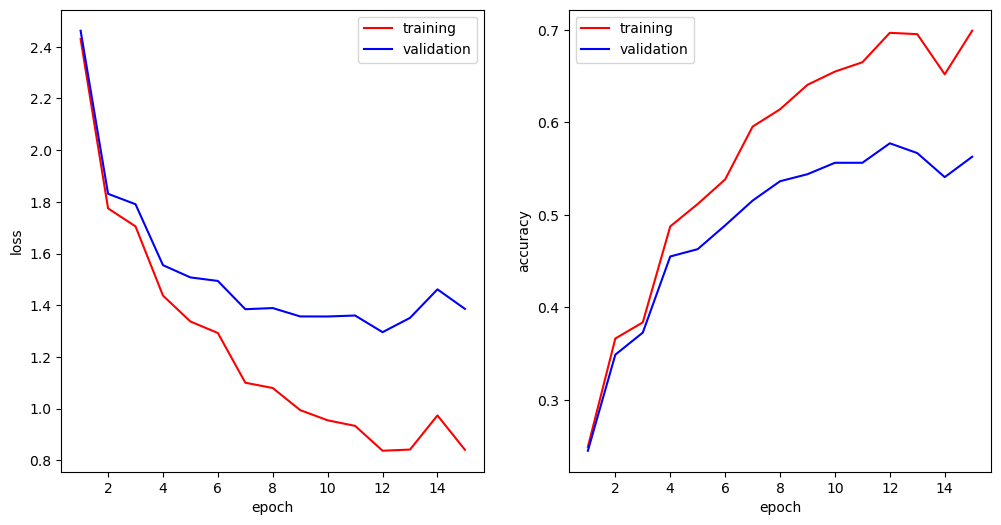

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.4366, Accuracy = 0.8288
client 2 : Loss = 0.1469, Accuracy = 0.9391
client 3 : Loss = 0.2421, Accuracy = 0.9130
client 4 : Loss = 0.3021, Accuracy = 0.8851
client 5 : Loss = 0.1745, Accuracy = 0.9412
client 6 : Loss = 0.1082, Accuracy = 0.9646
client 7 : Loss = 0.3688, Accuracy = 0.8632
client 8 : Loss = 0.4409, Accuracy = 0.8101

Server :
    - training loss = 2.2936
    - training accuracy = 0.2718
    - validation loss = 2.3378
    - validation accuracy = 0.2592
        
>>> Round 2 ...
client 1 : Loss = 0.3065, Accuracy = 0.8855
client 2 : Loss = 0.0998, Accuracy = 0.9646
client 3 : Loss = 0.1543, Accuracy = 0.9473
client 4 : Loss = 0.2103, Accuracy = 0.9229
client 5 : Loss = 0.2283, Accuracy = 0.9282
client 6 : Loss = 0.0663, Accuracy = 0.9810
cli

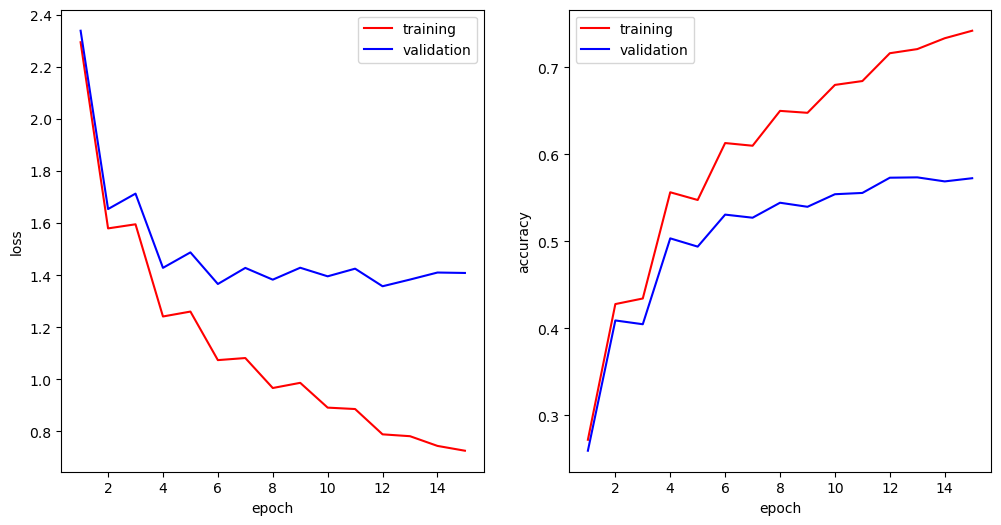

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 0.4121, Accuracy = 0.8403
client 2 : Loss = 0.1207, Accuracy = 0.9564
client 3 : Loss = 0.2231, Accuracy = 0.9166
client 4 : Loss = 0.3876, Accuracy = 0.8583
client 5 : Loss = 0.1818, Accuracy = 0.9443
client 6 : Loss = 0.1293, Accuracy = 0.9603
client 7 : Loss = 0.3133, Accuracy = 0.8864
client 8 : Loss = 0.4524, Accuracy = 0.8080

Server :
    - training loss = 2.4929
    - training accuracy = 0.2659
    - validation loss = 2.5340
    - validation accuracy = 0.2556
        
>>> Round 2 ...
client 1 : Loss = 0.2935, Accuracy = 0.8931
client 2 : Loss = 0.0849, Accuracy = 0.9699
client 3 : Loss = 0.1370, Accuracy = 0.9531
client 4 : Loss = 0.1917, Accuracy = 0.9294
client 5 : Loss = 0.1430, Accuracy = 0.9526
client 6 : Loss = 0.0636, Accuracy = 0.9818
cli

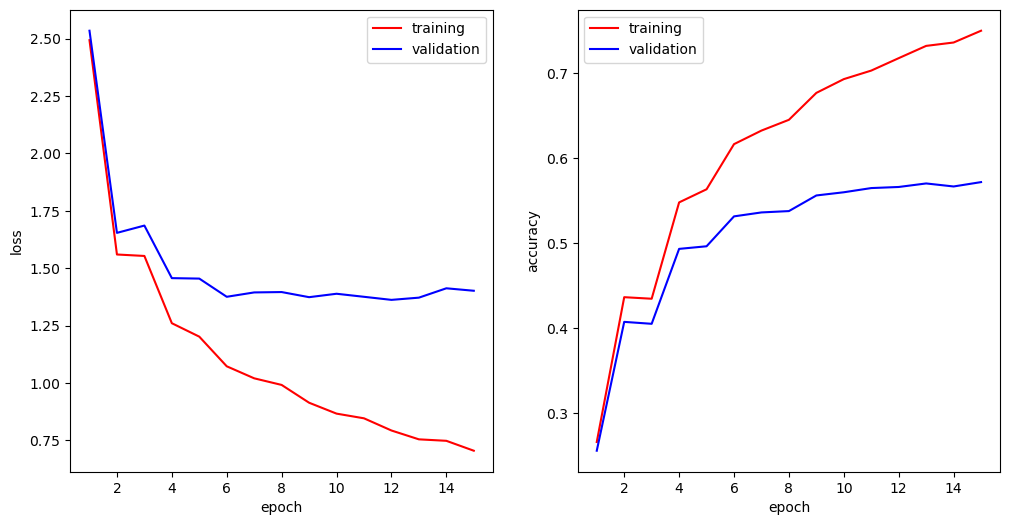

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.4335, Accuracy = 0.8338
client 2 : Loss = 0.1573, Accuracy = 0.9356
client 3 : Loss = 0.3465, Accuracy = 0.8702
client 4 : Loss = 0.3061, Accuracy = 0.8820
client 5 : Loss = 0.2358, Accuracy = 0.9153
client 6 : Loss = 0.1362, Accuracy = 0.9550
client 7 : Loss = 0.3649, Accuracy = 0.8674
client 8 : Loss = 0.4696, Accuracy = 0.7972

Server :
    - training loss = 2.0473
    - training accuracy = 0.3447
    - validation loss = 2.0658
    - validation accuracy = 0.3375
        
>>> Round 2 ...
client 1 : Loss = 0.3422, Accuracy = 0.8679
client 2 : Loss = 0.0919, Accuracy = 0.9665
client 3 : Loss = 0.2373, Accuracy = 0.9083
client 4 : Loss = 0.1966, Accuracy = 0.9253
client 5 : Loss = 0.1344, Accuracy = 0.9569
client 6 : Loss = 0.1101, Accuracy = 0.9658
cli

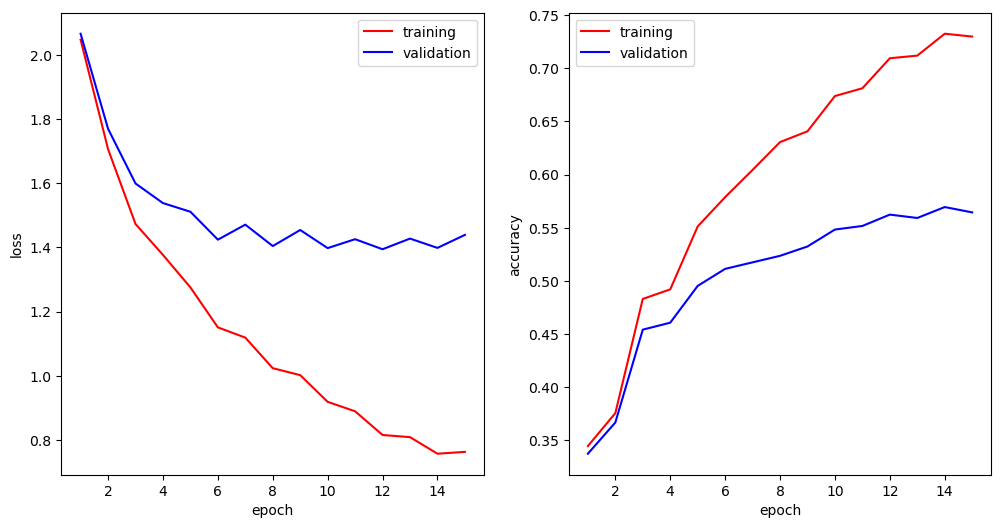

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.4517, Accuracy = 0.8295
client 2 : Loss = 0.1737, Accuracy = 0.9302
client 3 : Loss = 0.2057, Accuracy = 0.9229
client 4 : Loss = 0.2664, Accuracy = 0.9045
client 5 : Loss = 0.1122, Accuracy = 0.9653
client 6 : Loss = 0.1087, Accuracy = 0.9631
client 7 : Loss = 0.3534, Accuracy = 0.8697
client 8 : Loss = 0.4540, Accuracy = 0.8089

Server :
    - training loss = 2.3646
    - training accuracy = 0.2749
    - validation loss = 2.4144
    - validation accuracy = 0.2670
        
>>> Round 2 ...
client 1 : Loss = 0.3358, Accuracy = 0.8730
client 2 : Loss = 0.0909, Accuracy = 0.9685
client 3 : Loss = 0.1409, Accuracy = 0.9558
client 4 : Loss = 0.1838, Accuracy = 0.9322
client 5 : Loss = 0.0733, Accuracy = 0.9819
client 6 : Loss = 0.0801, Accuracy = 0.9784
cli

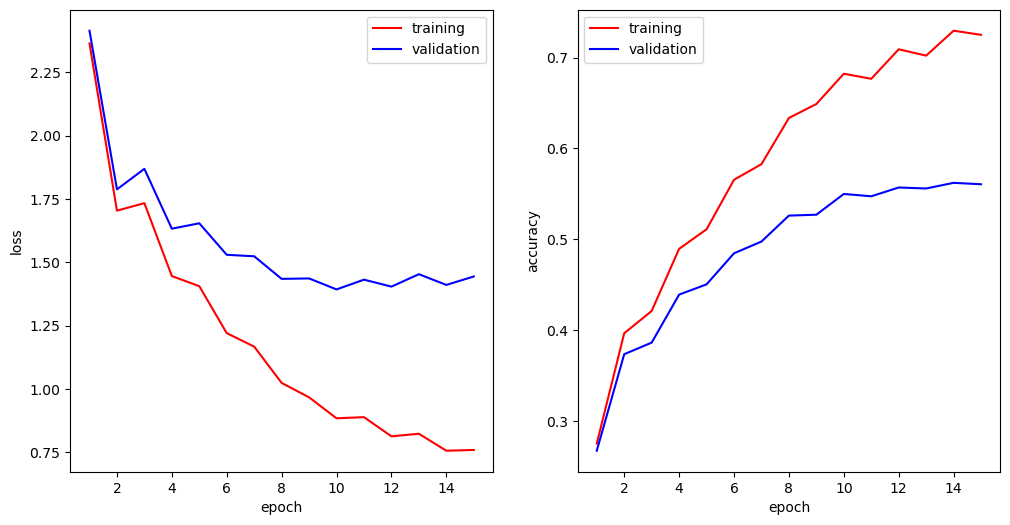

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.7301, Accuracy = 0.7156
client 2 : Loss = 0.2877, Accuracy = 0.8832
client 3 : Loss = 0.4488, Accuracy = 0.8446
client 4 : Loss = 0.5312, Accuracy = 0.7956
client 5 : Loss = 0.3517, Accuracy = 0.8740
client 6 : Loss = 0.3001, Accuracy = 0.9153
client 7 : Loss = 0.6943, Accuracy = 0.7438
client 8 : Loss = 0.5824, Accuracy = 0.7474

Server :
    - training loss = 2.1037
    - training accuracy = 0.2545
    - validation loss = 2.1411
    - validation accuracy = 0.2440
        
>>> Round 2 ...
client 1 : Loss = 0.7000, Accuracy = 0.7311
client 2 : Loss = 0.2496, Accuracy = 0.8984
client 3 : Loss = 0.3651, Accuracy = 0.8749
client 4 : Loss = 0.4686, Accuracy = 0.8221
client 5 : Loss = 0.2959, Accuracy = 0.8964
client 6 : Loss = 0.2586, Accuracy = 0.9194
cli

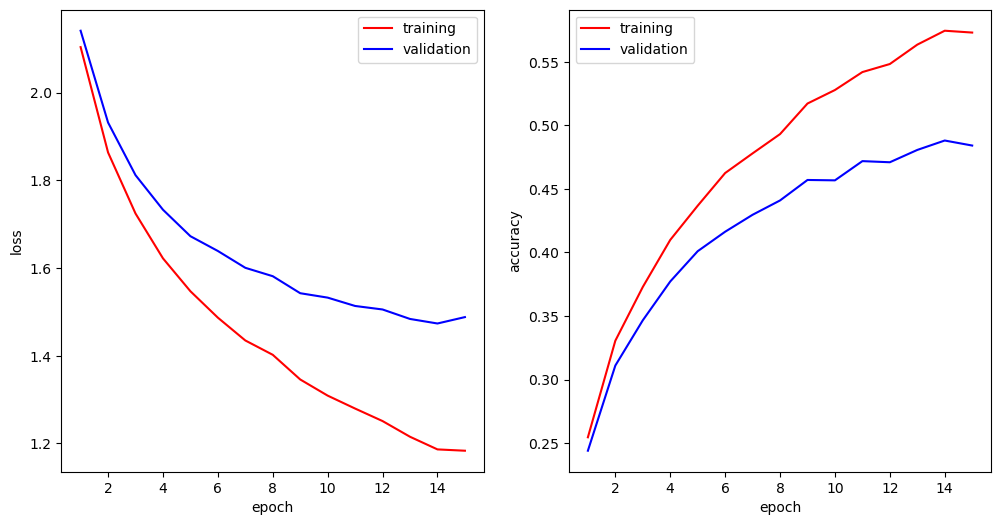

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.6547, Accuracy = 0.7425
client 2 : Loss = 0.2361, Accuracy = 0.9036
client 3 : Loss = 0.4253, Accuracy = 0.8502
client 4 : Loss = 0.4844, Accuracy = 0.8143
client 5 : Loss = 0.3515, Accuracy = 0.8804
client 6 : Loss = 0.2952, Accuracy = 0.9151
client 7 : Loss = 0.6464, Accuracy = 0.7719
client 8 : Loss = 0.5656, Accuracy = 0.7539

Server :
    - training loss = 2.1053
    - training accuracy = 0.2613
    - validation loss = 2.1373
    - validation accuracy = 0.2505
        
>>> Round 2 ...
client 1 : Loss = 0.5821, Accuracy = 0.7722
client 2 : Loss = 0.2236, Accuracy = 0.9137
client 3 : Loss = 0.3809, Accuracy = 0.8722
client 4 : Loss = 0.4141, Accuracy = 0.8433
client 5 : Loss = 0.3144, Accuracy = 0.8923
client 6 : Loss = 0.2553, Accuracy = 0.9211
cli

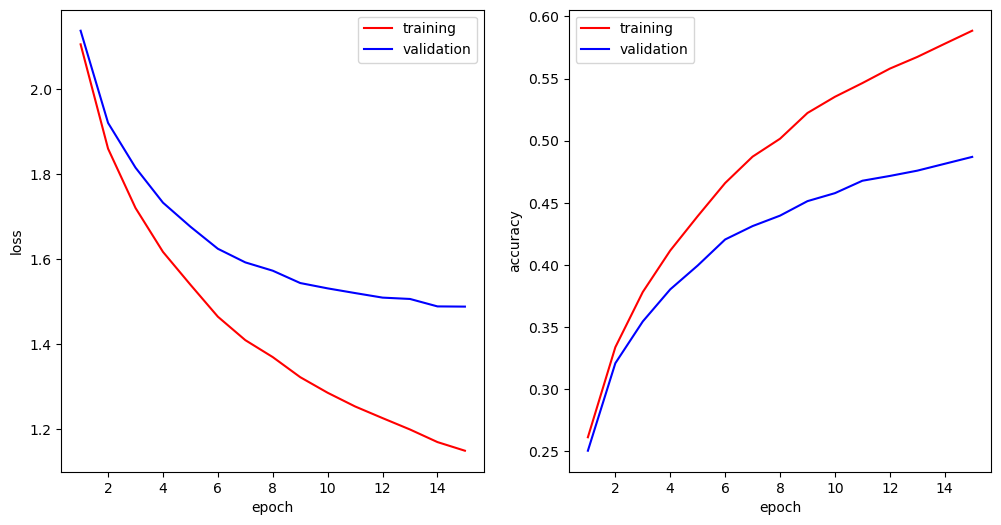

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 0.6944, Accuracy = 0.7258
client 2 : Loss = 0.2808, Accuracy = 0.8851
client 3 : Loss = 0.4462, Accuracy = 0.8502
client 4 : Loss = 0.5477, Accuracy = 0.7903
client 5 : Loss = 0.3636, Accuracy = 0.8653
client 6 : Loss = 0.2932, Accuracy = 0.9081
client 7 : Loss = 0.6988, Accuracy = 0.7476
client 8 : Loss = 0.6031, Accuracy = 0.7333

Server :
    - training loss = 2.1346
    - training accuracy = 0.2428
    - validation loss = 2.1681
    - validation accuracy = 0.2318
        
>>> Round 2 ...
client 1 : Loss = 0.6326, Accuracy = 0.7457
client 2 : Loss = 0.2589, Accuracy = 0.8948
client 3 : Loss = 0.3775, Accuracy = 0.8666
client 4 : Loss = 0.4700, Accuracy = 0.8198
client 5 : Loss = 0.3204, Accuracy = 0.8833
client 6 : Loss = 0.2601, Accuracy = 0.9137
cli

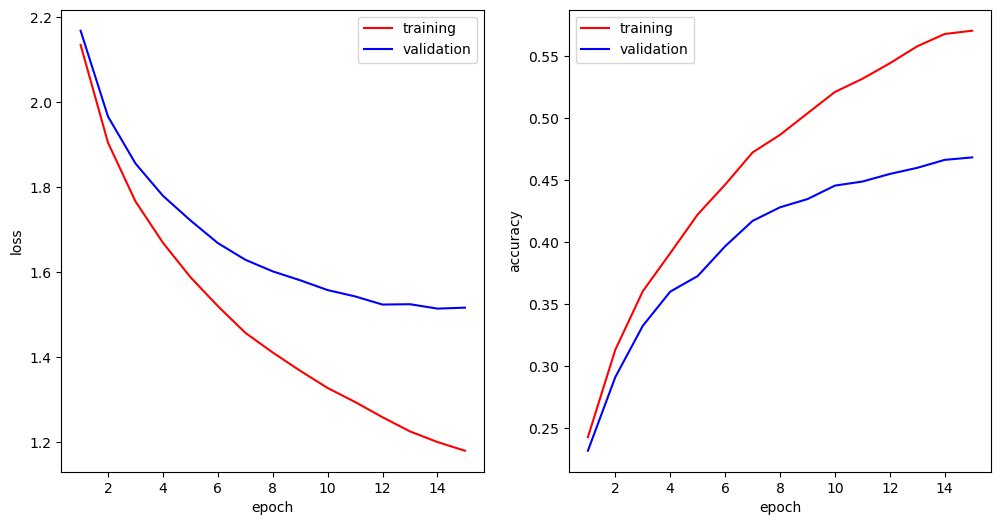

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.6676, Accuracy = 0.7336
client 2 : Loss = 0.2648, Accuracy = 0.8907
client 3 : Loss = 0.4738, Accuracy = 0.8376
client 4 : Loss = 0.5148, Accuracy = 0.8037
client 5 : Loss = 0.3289, Accuracy = 0.8825
client 6 : Loss = 0.3070, Accuracy = 0.9181
client 7 : Loss = 0.6605, Accuracy = 0.7607
client 8 : Loss = 0.5752, Accuracy = 0.7525

Server :
    - training loss = 2.0898
    - training accuracy = 0.2552
    - validation loss = 2.1314
    - validation accuracy = 0.2454
        
>>> Round 2 ...
client 1 : Loss = 0.5841, Accuracy = 0.7727
client 2 : Loss = 0.2401, Accuracy = 0.9003
client 3 : Loss = 0.3843, Accuracy = 0.8685
client 4 : Loss = 0.4465, Accuracy = 0.8292
client 5 : Loss = 0.3023, Accuracy = 0.8904
client 6 : Loss = 0.2716, Accuracy = 0.9174
cli

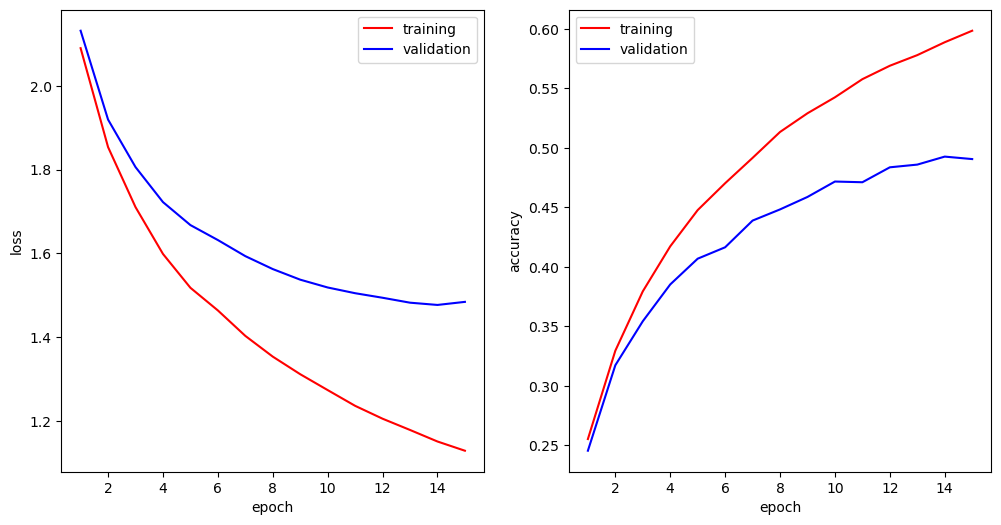

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.6761, Accuracy = 0.7296
client 2 : Loss = 0.2655, Accuracy = 0.8937
client 3 : Loss = 0.4365, Accuracy = 0.8538
client 4 : Loss = 0.5330, Accuracy = 0.7940
client 5 : Loss = 0.3620, Accuracy = 0.8756
client 6 : Loss = 0.2986, Accuracy = 0.9104
client 7 : Loss = 0.6597, Accuracy = 0.7704
client 8 : Loss = 0.5889, Accuracy = 0.7444

Server :
    - training loss = 2.0937
    - training accuracy = 0.2605
    - validation loss = 2.1389
    - validation accuracy = 0.2460
        
>>> Round 2 ...
client 1 : Loss = 0.6085, Accuracy = 0.7638
client 2 : Loss = 0.2420, Accuracy = 0.9057
client 3 : Loss = 0.3865, Accuracy = 0.8655
client 4 : Loss = 0.4490, Accuracy = 0.8307
client 5 : Loss = 0.2921, Accuracy = 0.9006
client 6 : Loss = 0.2687, Accuracy = 0.9216
cli

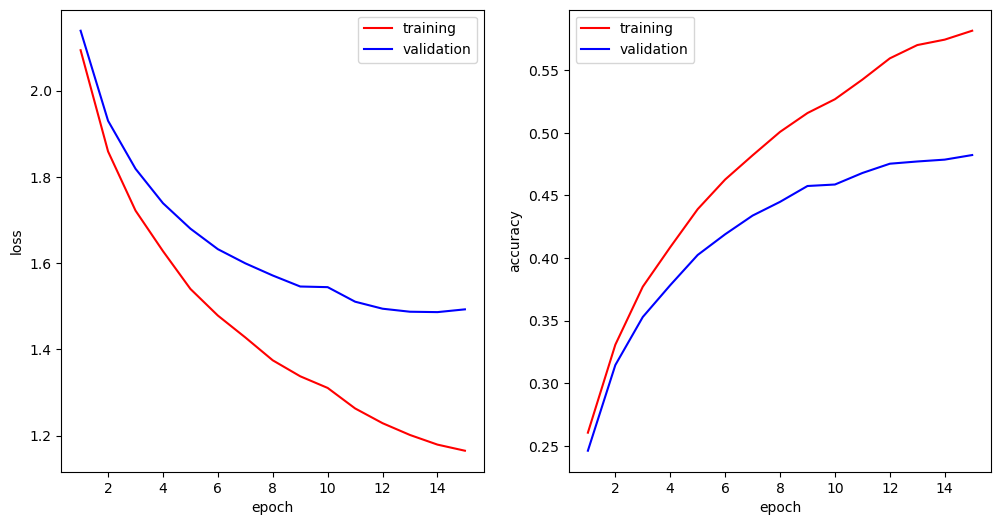

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 1.2187, Accuracy = 0.5589
client 2 : Loss = 0.6309, Accuracy = 0.7806
client 3 : Loss = 0.9111, Accuracy = 0.7584
client 4 : Loss = 1.0091, Accuracy = 0.6083
client 5 : Loss = 0.9397, Accuracy = 0.7147
client 6 : Loss = 0.7608, Accuracy = 0.8445
client 7 : Loss = 1.3302, Accuracy = 0.5639
client 8 : Loss = 0.9275, Accuracy = 0.6145

Server :
    - training loss = 2.2953
    - training accuracy = 0.1810
    - validation loss = 2.2890
    - validation accuracy = 0.1841
        
>>> Round 2 ...
client 1 : Loss = 1.1754, Accuracy = 0.5642
client 2 : Loss = 0.5952, Accuracy = 0.7937
client 3 : Loss = 0.8326, Accuracy = 0.7795
client 4 : Loss = 0.9528, Accuracy = 0.6275
client 5 : Loss = 0.8601, Accuracy = 0.7401
client 6 : Loss = 0.6859, Accuracy = 0.8500
cli

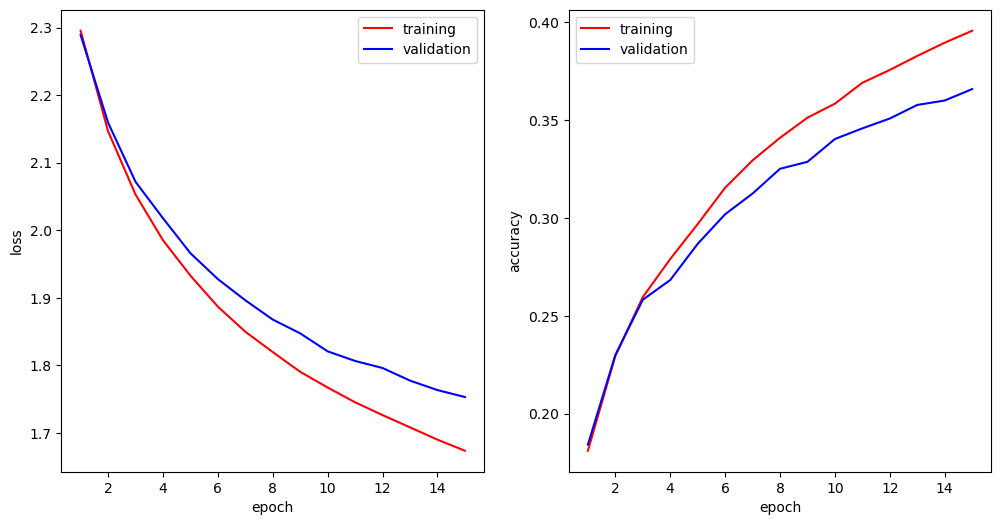

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 1.2097, Accuracy = 0.5517
client 2 : Loss = 0.5982, Accuracy = 0.7887
client 3 : Loss = 0.8989, Accuracy = 0.7482
client 4 : Loss = 1.0438, Accuracy = 0.5920
client 5 : Loss = 0.9194, Accuracy = 0.7088
client 6 : Loss = 0.7058, Accuracy = 0.8492
client 7 : Loss = 1.2974, Accuracy = 0.5754
client 8 : Loss = 0.9206, Accuracy = 0.6175

Server :
    - training loss = 2.3663
    - training accuracy = 0.1684
    - validation loss = 2.3615
    - validation accuracy = 0.1743
        
>>> Round 2 ...
client 1 : Loss = 1.1711, Accuracy = 0.5728
client 2 : Loss = 0.5907, Accuracy = 0.7925
client 3 : Loss = 0.8342, Accuracy = 0.7714
client 4 : Loss = 0.9726, Accuracy = 0.6249
client 5 : Loss = 0.8725, Accuracy = 0.7482
client 6 : Loss = 0.6566, Accuracy = 0.8532
cli

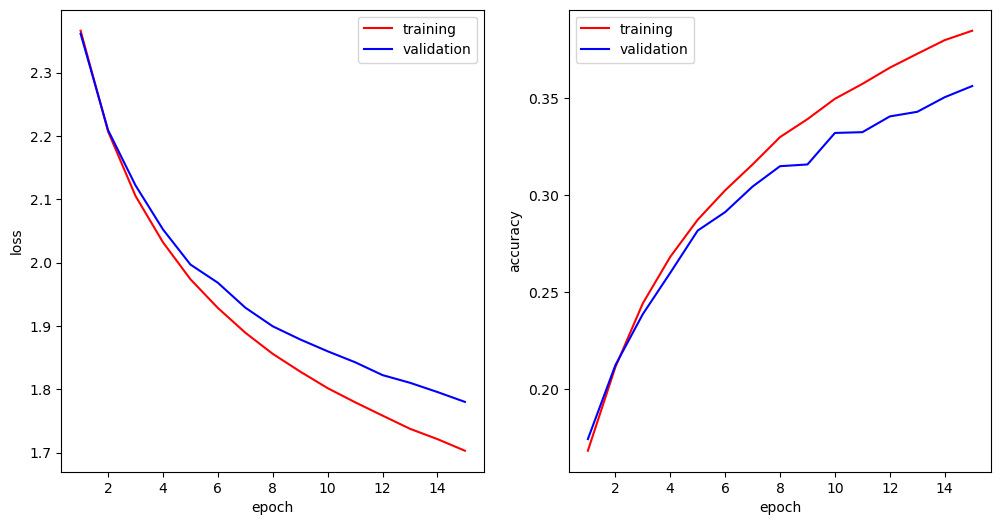

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 1.2214, Accuracy = 0.5489
client 2 : Loss = 0.6261, Accuracy = 0.7741
client 3 : Loss = 0.8902, Accuracy = 0.7361
client 4 : Loss = 1.0685, Accuracy = 0.5861
client 5 : Loss = 0.9592, Accuracy = 0.7056
client 6 : Loss = 0.7106, Accuracy = 0.8399
client 7 : Loss = 1.3219, Accuracy = 0.5691
client 8 : Loss = 0.9170, Accuracy = 0.6200

Server :
    - training loss = 2.3211
    - training accuracy = 0.1744
    - validation loss = 2.3281
    - validation accuracy = 0.1710
        
>>> Round 2 ...
client 1 : Loss = 1.1474, Accuracy = 0.5773
client 2 : Loss = 0.6135, Accuracy = 0.7802
client 3 : Loss = 0.8735, Accuracy = 0.7550
client 4 : Loss = 1.0020, Accuracy = 0.6119
client 5 : Loss = 0.9021, Accuracy = 0.7245
client 6 : Loss = 0.6777, Accuracy = 0.8564
cli

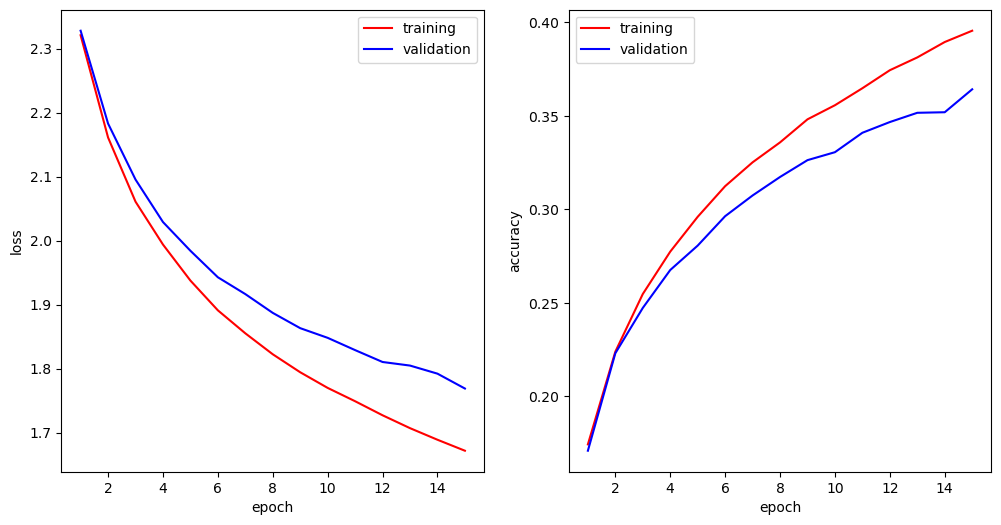

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 1.2189, Accuracy = 0.5557
client 2 : Loss = 0.6155, Accuracy = 0.7950
client 3 : Loss = 0.8967, Accuracy = 0.7527
client 4 : Loss = 1.0610, Accuracy = 0.5844
client 5 : Loss = 0.9936, Accuracy = 0.6864
client 6 : Loss = 0.7274, Accuracy = 0.8395
client 7 : Loss = 1.3478, Accuracy = 0.5706
client 8 : Loss = 0.9350, Accuracy = 0.6135

Server :
    - training loss = 2.3151
    - training accuracy = 0.1754
    - validation loss = 2.3292
    - validation accuracy = 0.1712
        
>>> Round 2 ...
client 1 : Loss = 1.1609, Accuracy = 0.5746
client 2 : Loss = 0.5922, Accuracy = 0.7957
client 3 : Loss = 0.8126, Accuracy = 0.7762
client 4 : Loss = 0.9986, Accuracy = 0.6033
client 5 : Loss = 0.9421, Accuracy = 0.7172
client 6 : Loss = 0.6263, Accuracy = 0.8534
cli

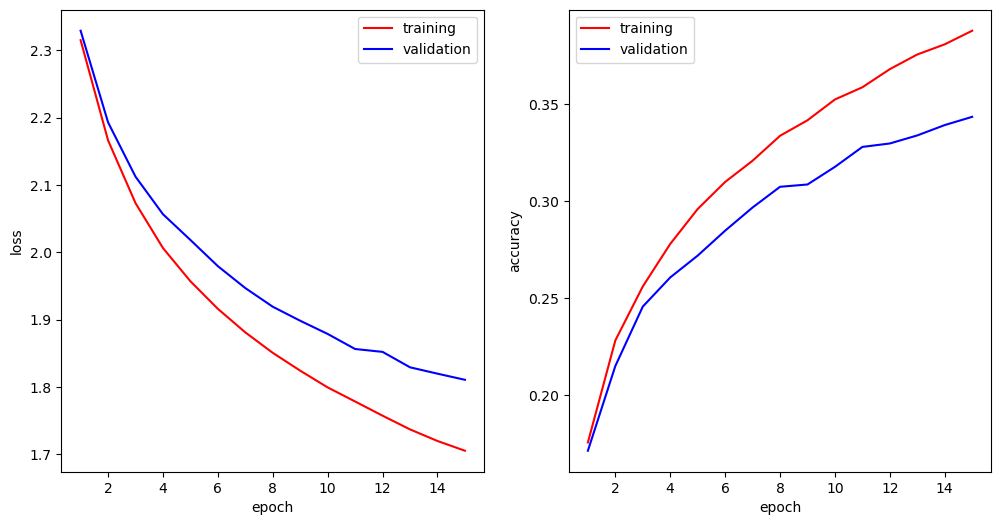

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 1.2505, Accuracy = 0.5393
client 2 : Loss = 0.5924, Accuracy = 0.7918
client 3 : Loss = 0.8898, Accuracy = 0.7538
client 4 : Loss = 1.0516, Accuracy = 0.5954
client 5 : Loss = 1.0388, Accuracy = 0.6827
client 6 : Loss = 0.7274, Accuracy = 0.8474
client 7 : Loss = 1.3528, Accuracy = 0.5647
client 8 : Loss = 0.9246, Accuracy = 0.6103

Server :
    - training loss = 2.3585
    - training accuracy = 0.1631
    - validation loss = 2.3864
    - validation accuracy = 0.1515
        
>>> Round 2 ...
client 1 : Loss = 1.1737, Accuracy = 0.5676
client 2 : Loss = 0.5694, Accuracy = 0.7966
client 3 : Loss = 0.7980, Accuracy = 0.7855
client 4 : Loss = 0.9916, Accuracy = 0.6203
client 5 : Loss = 0.9163, Accuracy = 0.7246
client 6 : Loss = 0.6678, Accuracy = 0.8550
cli

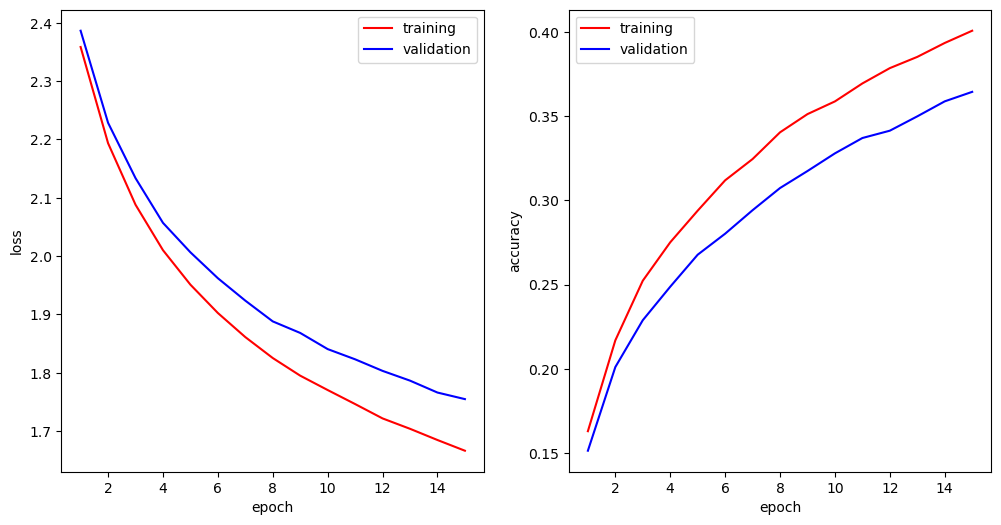

RESULTS
lr = 0.1000 : Accuracy = 0.6102056503295898
lr = 0.0100 : Accuracy = 0.5664359331130981
lr = 0.0010 : Accuracy = 0.48247623443603516
lr = 0.0001 : Accuracy = 0.3588014245033264

CPU times: user 5h 6min 21s, sys: 52 s, total: 5h 7min 13s
Wall time: 5h 8min 37s


In [12]:
%%time
n_splits = 5
rounds = 15
batch_size = 128
epochs = 5
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
optimizer = optim.SGD

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,momentum=0.9)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()